In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mysql.connector


In [2]:
from scipy.stats import ttest_ind  # for hypothesis testing

In [3]:
import scipy.stats as stats  # for stats model

##EXPLORATORY DATA ANALYSIS

Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.
In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [4]:
df = pd.read_excel('D:/NIKHIL/SUPPLY CHAIN PROJECT - VENDOR PERFORMANCE ANALYSIS/vendor_sales_summary.xlsx')

In [5]:
df.describe().T  # to see summary statistics . Here .T means transpose. Here in some solumns there are values like 5.681810e+03 in scientific notation means 
                 #  5.681810 × 10^3 which is 5,681.81

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,18039.228769,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,24.385303,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,35.643671,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,847.360550,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchasequantity,10692.0,3140.886831,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,30106.693372,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,12309.928545,43811.405563,0.00,132.000000,1044.000000,7717.000000,1.339756e+06
TotalSalesDollars,10692.0,168956.297677,670621.063935,0.00,2916.880000,21192.180000,113587.660000,2.040768e+07
TotalSalesPrice,10692.0,75175.134508,179811.093542,0.00,1158.840000,11431.200000,64238.250000,2.691277e+06


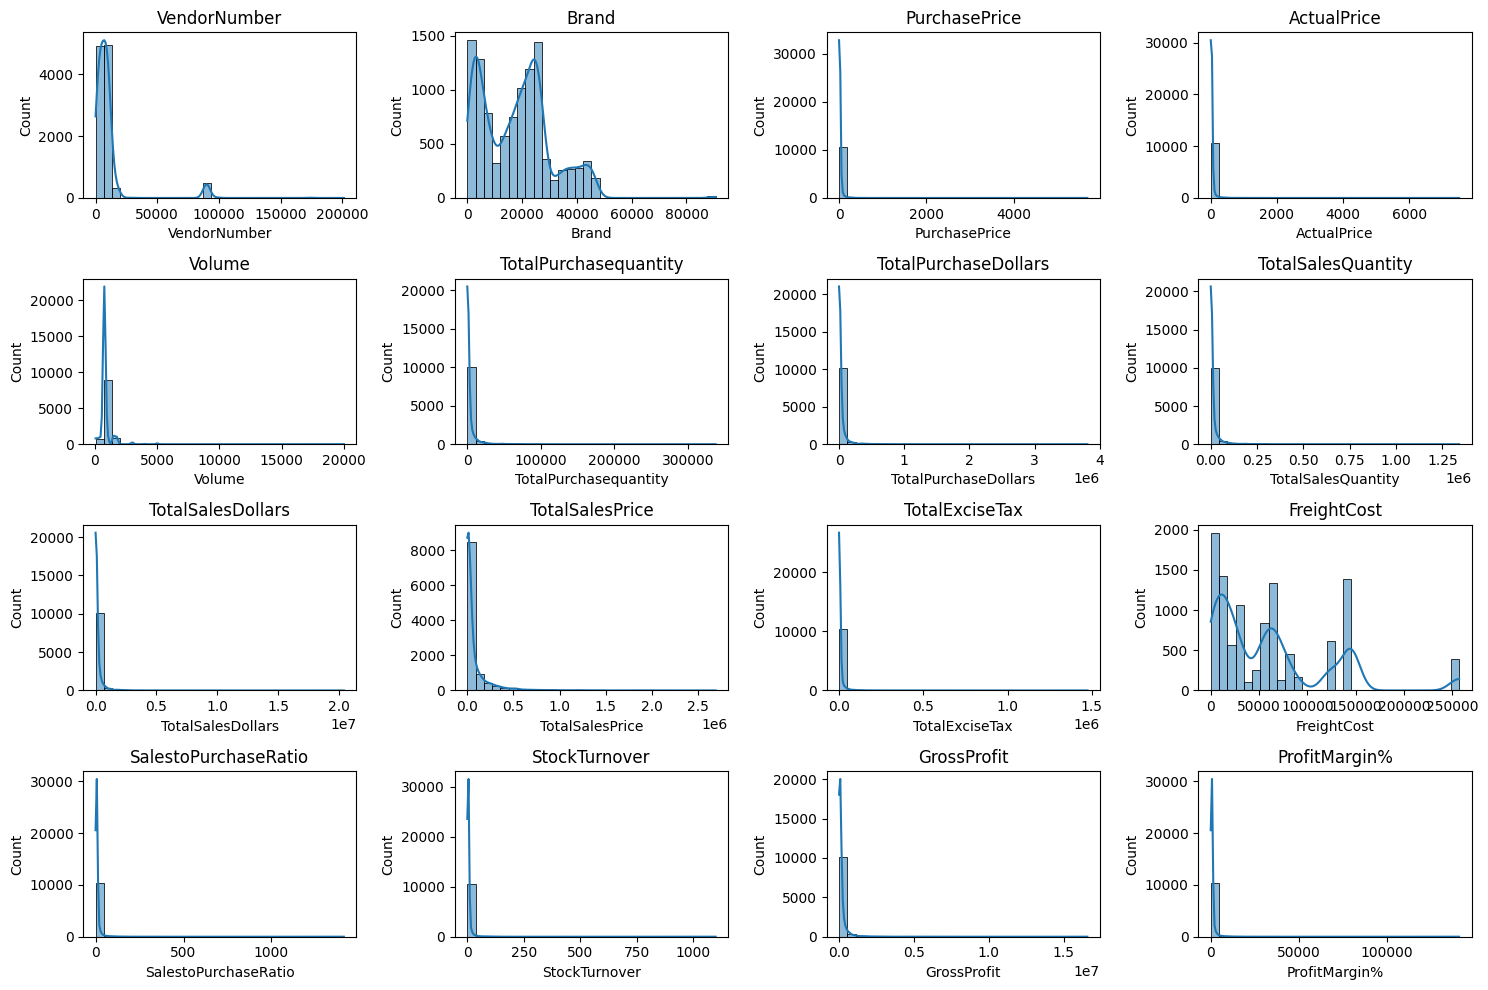

In [6]:
# Distribution Plots for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)     # adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins =30)
    plt.title(col)
plt.tight_layout()
plt.show()

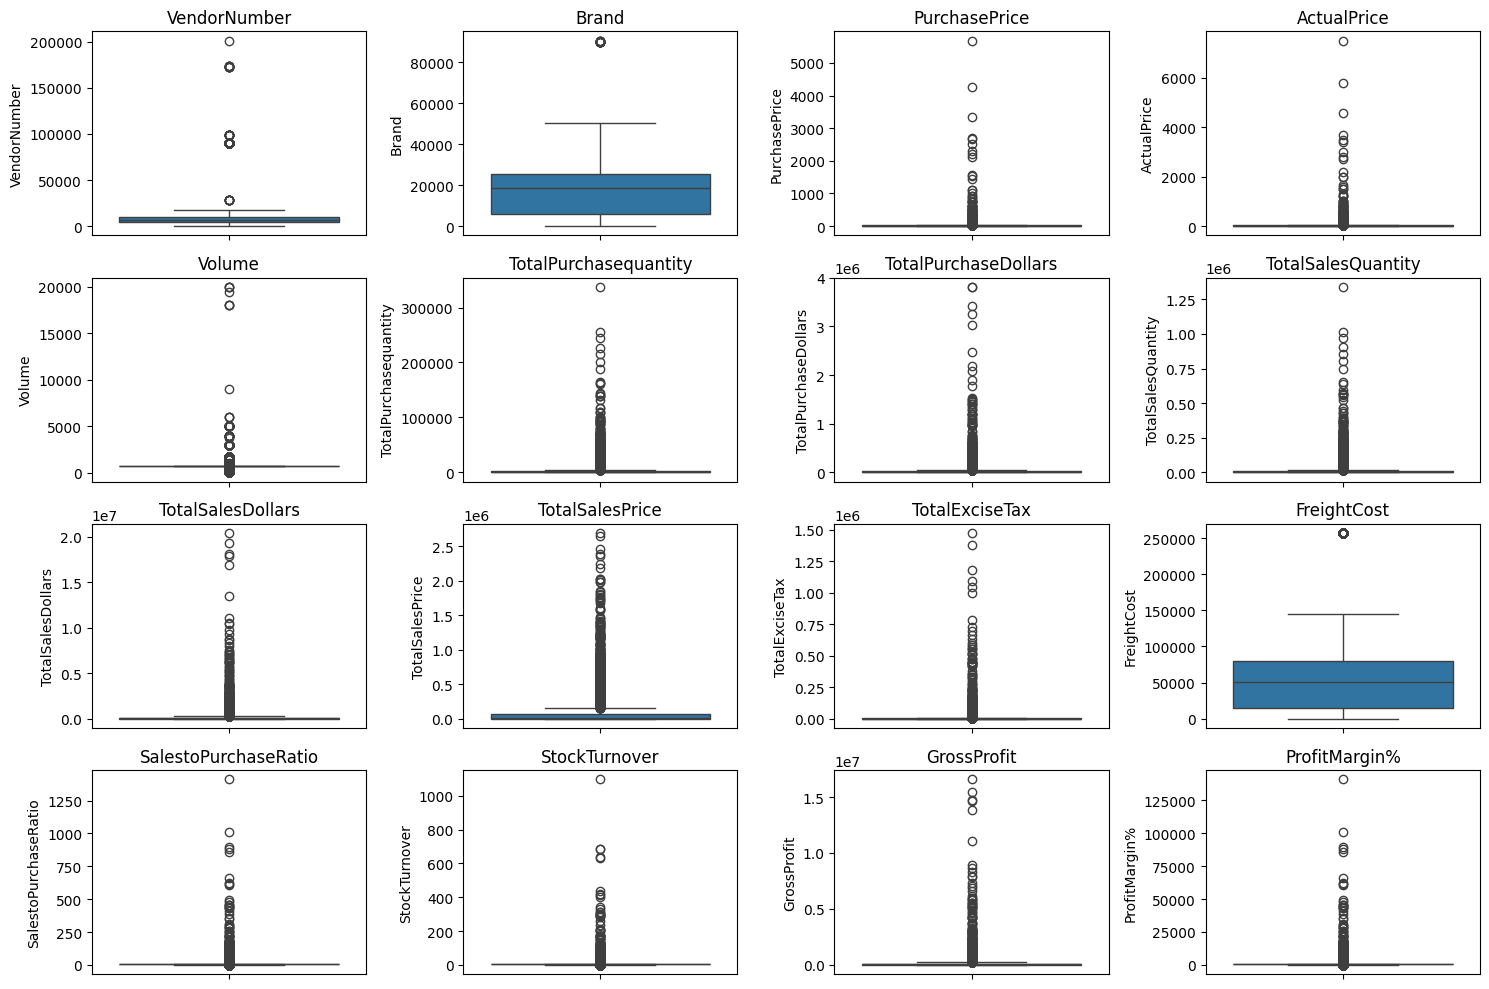

In [7]:
# Outlier Detection with Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df [col])
    plt.title(col)
plt.tight_layout()
plt.show()

Summary Statistics Insights:

Negative & Zero Values:

* Gross Profit: Minimum value is -28614.08, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price..
* Profit Margin: Has a minimum of-00, which suggests cases where revenue is zero or even lower than costs.
* Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.
* Outliers Indicated by High Standard Deviations:
* Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.
* Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.
* Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that
Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.

In [8]:
# Lets filter the data by removing inconsistencies

df = df[
    (df['GrossProfit']>0) &
    (df['ProfitMargin%']>0) &
    (df['TotalSalesQuantity']>0)
]

In [9]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchasequantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,SalestoPurchaseRatio,StockTurnover,GrossProfit,ProfitMargin%
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,568196,20407678.04,2691277.24,1043996.80,68601.68,5.354587,3.916432,16596426.44,435.458694
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,640988,19276293.96,2246049.48,1177754.64,144929.24,5.067320,3.907558,15472252.74,406.731995
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,748560,18152482.40,1844560.60,1375416.28,123780.22,5.310377,3.994301,14734178.72,431.037734
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,801648,17903891.52,1680200.04,1472971.20,257032.07,5.489974,3.974812,14642693.58,448.997388
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,543352,16892430.48,2183113.12,998351.32,257032.07,5.587588,3.934226,13869224.47,458.758828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,20,63.80,43.84,2.20,27100.41,24.166667,10.000000,61.16,2316.666667
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,536,262.64,5.88,28.16,50293.62,112.239316,89.333333,260.30,11123.931624
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,8,7.92,3.96,0.40,14069.87,5.351351,4.000000,6.44,435.135135
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,288,573.12,310.44,60.48,257032.07,389.877551,288.000000,571.65,38887.755102


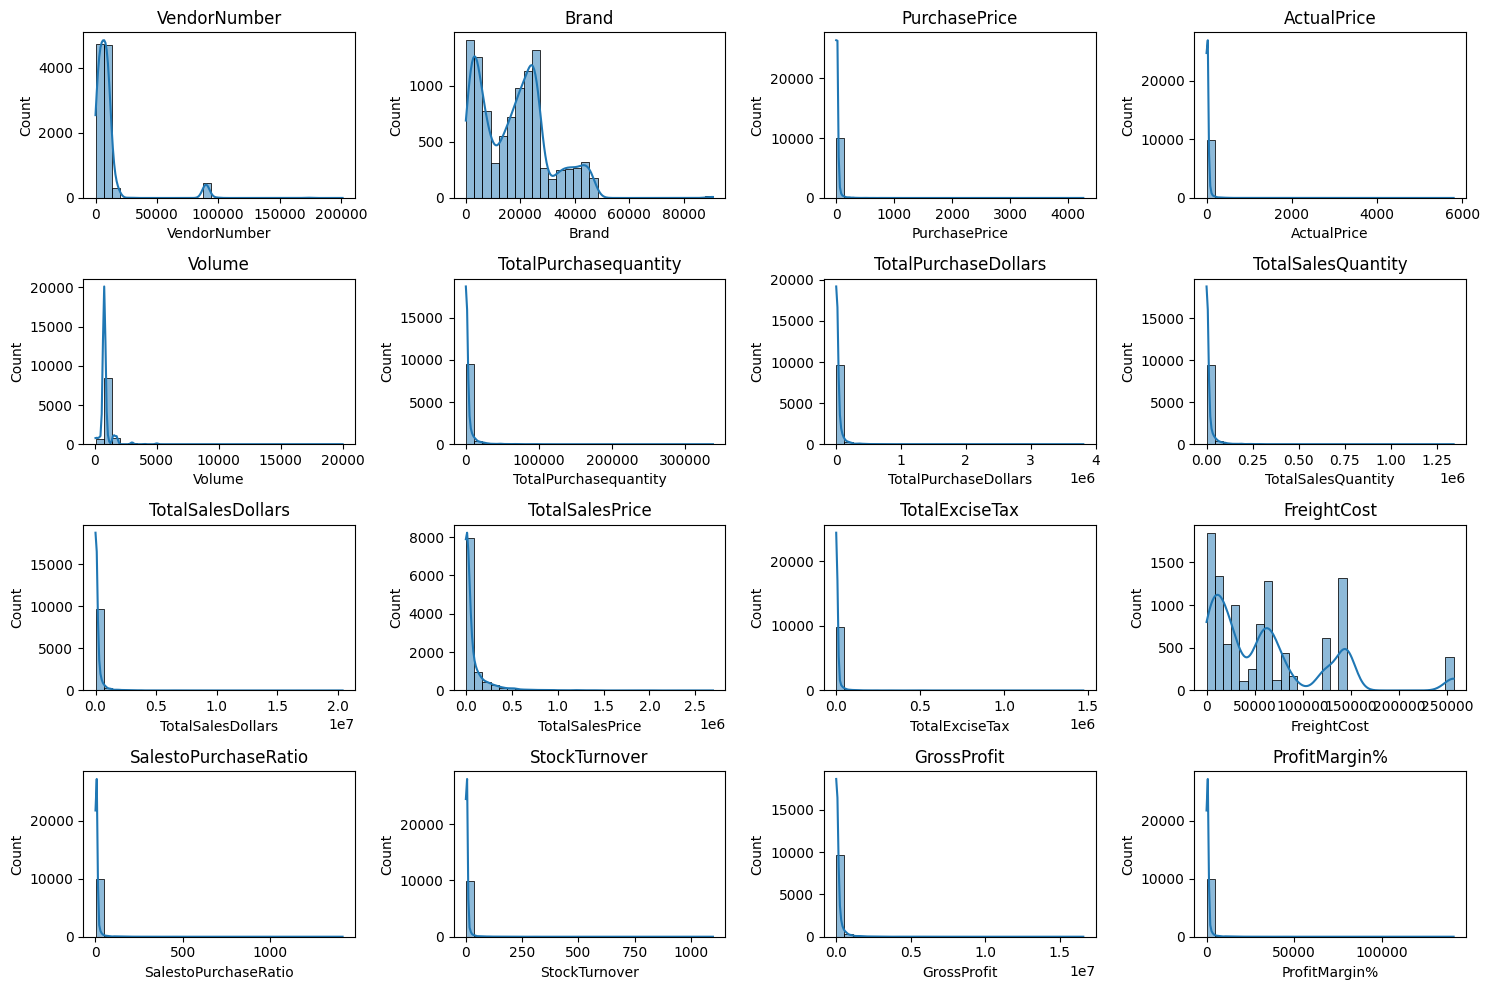

In [10]:
# Distribution Plots for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)     # adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins =30)
    plt.title(col)
plt.tight_layout()
plt.show()

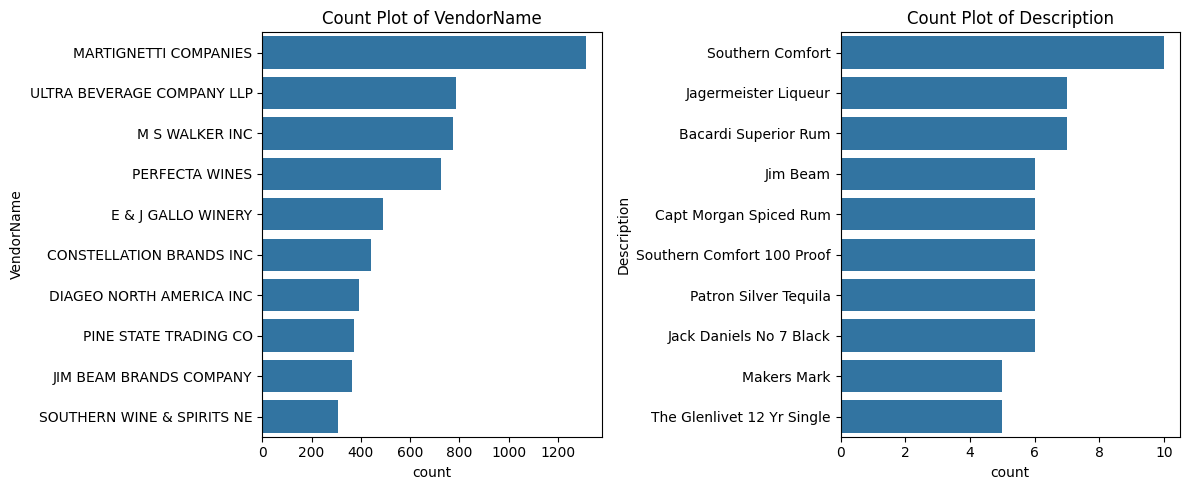

In [11]:
# Count Plots for Categorical Columns    To find top 10 brands and vendors.
categorical_cols = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])   # Top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

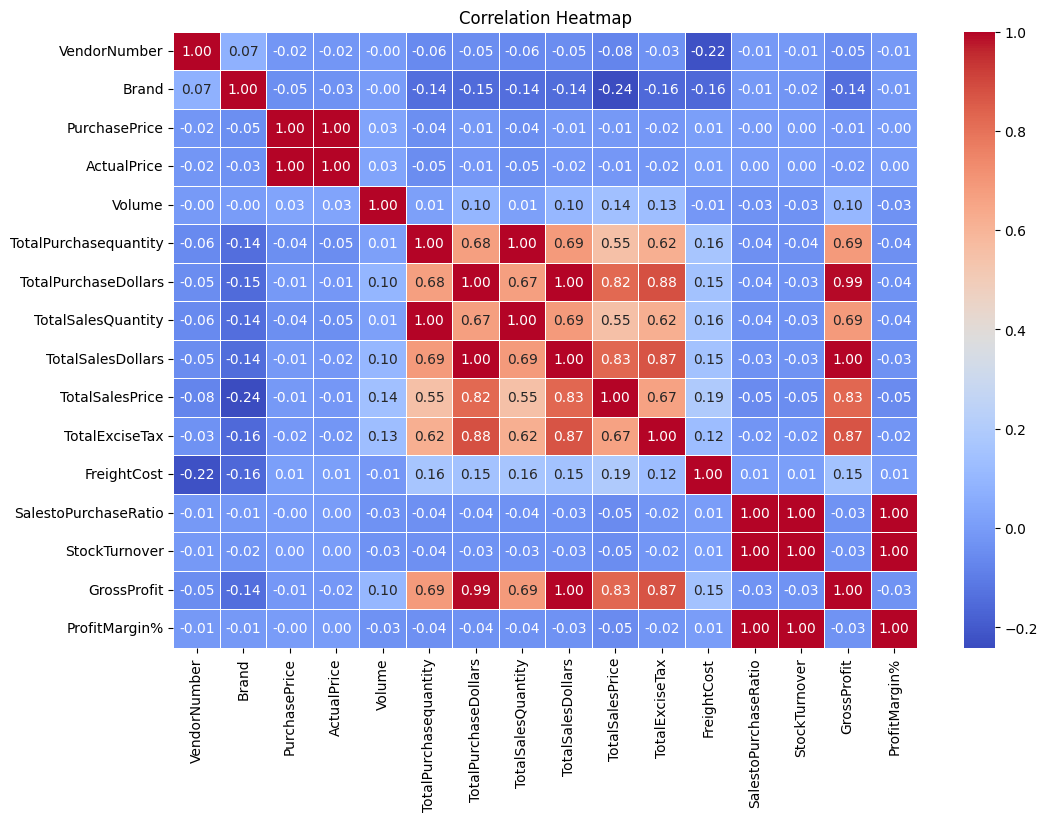

In [12]:
# Correlation Heatmap

plt.figure(figsize=(12, 8))
correlation_matrix = df [numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

###Correlation Insights
* Purchase Price has weak correlations with TotalSales Dollars (-0.012) and GrossProfit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.
* Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.
* Negative correlation between profit margin & total sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.
* Stock Turnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.

#DATA ANALYSIS  - SOLVING BUSINESS PROBLEMS AND QUESTIONS

Identify Brands that needs Promotional or Pricing Adjustments which exhibit lower sales performance but higher profit margins.

In [13]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin%':'mean'
}).reset_index()

brand_performance

,Description,TotalSalesDollars,ProfitMargin%
0,(RI) 1,86076.36,388.166011
1,.nparalleled Svgn Blanc,4378.52,471.250391
2,10 Span Cab Svgn CC,10815.56,405.929571
3,10 Span Chard CC,13302.24,454.066077
4,10 Span Pnt Gris Monterey Cy,8328.88,490.198413
...,...,...,...
9161,Zuccardi Q Malbec,6556.72,426.187725
9162,Zum Rsl,43429.36,494.133275
9163,Zwack Liqueur,911.52,379.924183
9164,g Sake,3279.68,136.417635


In [14]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15) # Where TotalSalesDollars is less than 15%
high_margin_threshold = brand_performance['ProfitMargin%'].quantile(0.85)       #HERE we are setting threshold

In [15]:
high_margin_threshold

np.float64(873.0648616845494)

In [16]:
# Filter brands with low sales but high profit margins
target_brands = brand_performance[
(brand_performance ['TotalSalesDollars'] <= low_sales_threshold) &
(brand_performance ['ProfitMargin%'] >= high_margin_threshold)
]
print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin%
7378,Santa Rita Organic Svgn Bl,39.96,1092.835821
2771,Debauchery Pnt Nr,46.32,1075.634518
2431,Concannon Glen Ellen Wh Zin,63.80,2316.666667
2562,Crown Royal Apple,111.44,3823.943662
7418,Sauza Sprklg Wild Berry Marg,111.84,2141.282565
...,...,...,...
543,Bacardi Oakheart Spiced Trav,1598.40,21326.273458
3500,Flowers Sonoma Cst Pnt Nr,1599.84,2300.000000
7093,Riebeek Cellars Chard,1614.44,876.318336
3337,Fattoria Del Cerro Vino Nob,1618.80,1429.478458


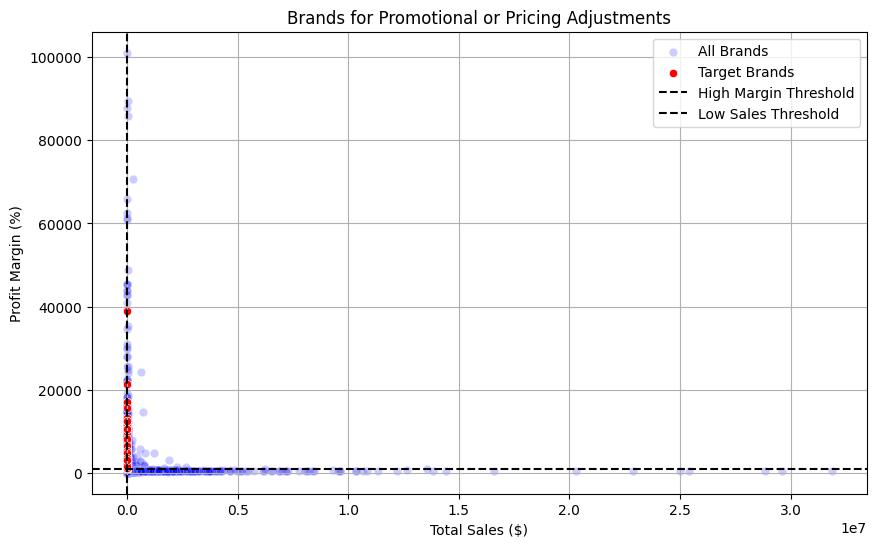

In [17]:
#Analysing the above using scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin%', color="blue", label="All Brands", alpha= 0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin%', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

Which vendors and brands demonstrate the highest sales performance?

In [18]:
def format_dollars (value):    # defining dollar format to present in readable format
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)

In [19]:
# Top Vendors & Brands by Sales Performance
top_vendors = df.groupby("VendorName") ["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby ("Description") ["TotalSalesDollars"].sum().nlargest(10)
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      2.749251e+08
MARTIGNETTI COMPANIES         1.637435e+08
PERNOD RICARD USA             1.291182e+08
JIM BEAM BRANDS COMPANY       1.275762e+08
BACARDI USA INC               1.000215e+08
CONSTELLATION BRANDS INC      9.786768e+07
E & J GALLO WINERY            7.421096e+07
BROWN-FORMAN CORP             7.389836e+07
ULTRA BEVERAGE COMPANY LLP    7.104768e+07
M S WALKER INC                6.164752e+07
Name: TotalSalesDollars, dtype: float64

In [20]:
top_brands.apply(lambda x : format_dollars(x))

Description
Jack Daniels No 7 Black    31.86M
Tito's Handmade Vodka      29.60M
Grey Goose Vodka           28.84M
Capt Morgan Spiced Rum     25.43M
Absolut 80 Proof           24.98M
Jameson Irish Whiskey      22.86M
Ketel One Vodka            20.28M
Baileys Irish Cream        16.60M
Kahlua                     14.42M
Tanqueray                  13.83M
Name: TotalSalesDollars, dtype: object

C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\3927209750.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 =  sns.barplot(y=top_vendors. index, x=top_vendors.values, palette="Blues_r")
C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\3927209750.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 =  sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")


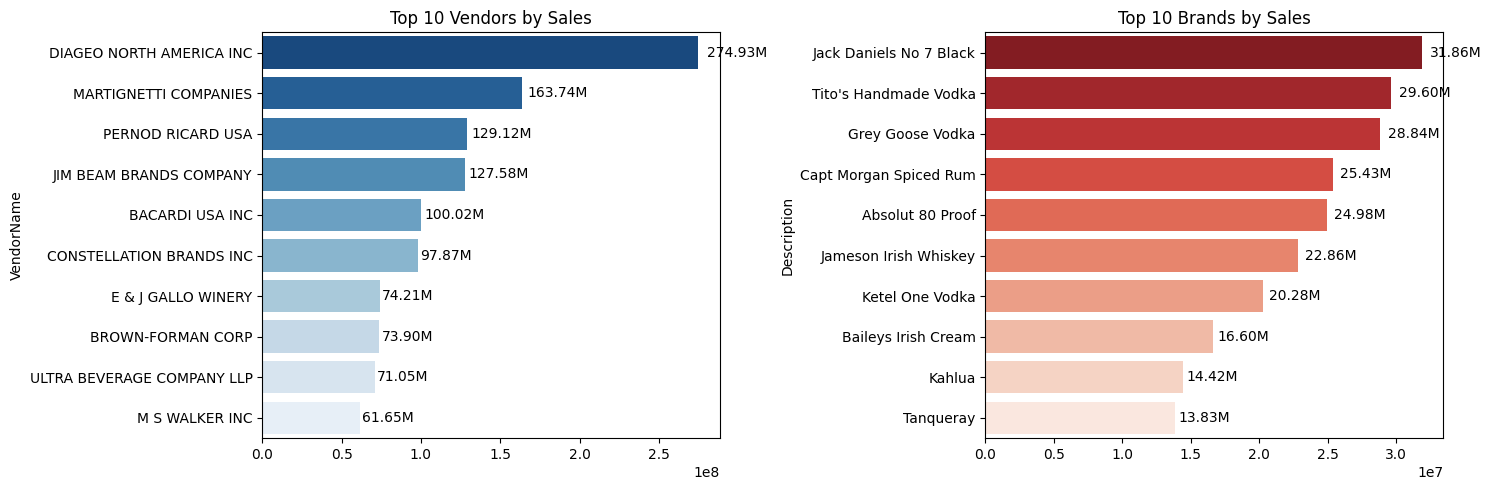

In [21]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 =  sns.barplot(y=top_vendors. index, x=top_vendors.values, palette="Blues_r") 
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02), 
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()), ha='left', va='center', fontsize=10, color='black')
    

#Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 =  sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha = 'left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

Which vendors contribute the most to total purchase dollars?

In [22]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit': 'sum',
    'TotalSalesDollars': 'sum'
}).reset_index()

In [23]:
vendor_performance ['PurchaseContribution%'] = vendor_performance ['TotalPurchaseDollars']/vendor_performance ['TotalPurchaseDollars'].sum()*100
    # this is to find out the purchase contribution of each vendor

In [24]:
vendor_performance = round(vendor_performance.sort_values('PurchaseContribution%', ascending=False),2)

In [25]:
# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\2774283761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\2774283761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\2774283761.py:5: SettingWithCopyWarning: 
A value is 

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
27,DIAGEO NORTH AMERICA INC,50.91M,224.01M,274.93M,15.89
61,MARTIGNETTI COMPANIES,27.62M,136.12M,163.74M,8.62
49,JIM BEAM BRANDS COMPANY,24.16M,103.42M,127.58M,7.54
72,PERNOD RICARD USA,24.12M,104.99M,129.12M,7.53
7,BACARDI USA INC,17.62M,82.40M,100.02M,5.50
22,CONSTELLATION BRANDS INC,15.57M,82.30M,97.87M,4.86
13,BROWN-FORMAN CORP,13.51M,60.39M,73.90M,4.22
111,ULTRA BEVERAGE COMPANY LLP,12.84M,58.21M,71.05M,4.01
32,E & J GALLO WINERY,12.28M,61.93M,74.21M,3.83
57,M S WALKER INC,10.67M,50.98M,61.65M,3.33


In [26]:
top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()
top_vendors

C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\2063587715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()


,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,Cumulative_Contribution%
27,DIAGEO NORTH AMERICA INC,50.91M,224.01M,274.93M,15.89,15.89
61,MARTIGNETTI COMPANIES,27.62M,136.12M,163.74M,8.62,24.51
49,JIM BEAM BRANDS COMPANY,24.16M,103.42M,127.58M,7.54,32.05
72,PERNOD RICARD USA,24.12M,104.99M,129.12M,7.53,39.58
7,BACARDI USA INC,17.62M,82.40M,100.02M,5.50,45.08
22,CONSTELLATION BRANDS INC,15.57M,82.30M,97.87M,4.86,49.94
13,BROWN-FORMAN CORP,13.51M,60.39M,73.90M,4.22,54.16
111,ULTRA BEVERAGE COMPANY LLP,12.84M,58.21M,71.05M,4.01,58.17
32,E & J GALLO WINERY,12.28M,61.93M,74.21M,3.83,62.00
57,M S WALKER INC,10.67M,50.98M,61.65M,3.33,65.33


C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\4095994000.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], palette="mako", ax=ax1)
C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\4095994000.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels (top_vendors ['VendorName'], rotation=90)


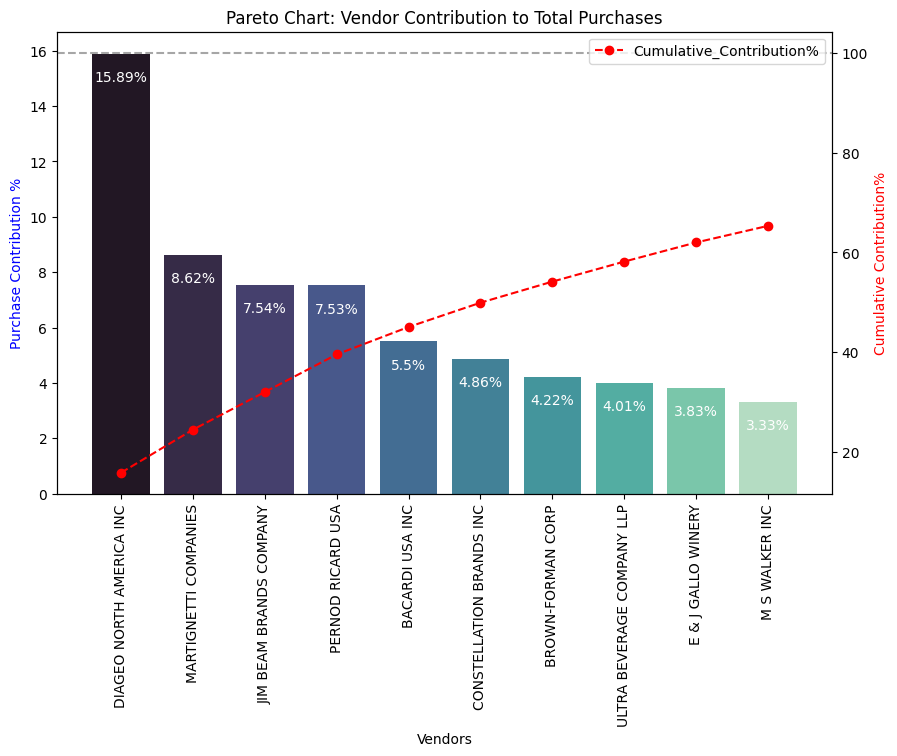

In [28]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contributions%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], palette="mako", ax=ax1)

for i, value in enumerate (top_vendors ['PurchaseContribution%']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution%
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], color='red', marker='o', linestyle='dashed', label='Cumulative_Contribution%')
         
ax1.set_xticklabels (top_vendors ['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution%', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline( y = 100 ,color='gray', linestyle='dashed', alpha=0.7)
ax2. legend (loc='upper right')
plt.show()

How much of total procurement is dependent on the top vendors?

In [30]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors ['PurchaseContribution%'].sum(),2)}%")

Total Purchase Contribution of top 10 vendors is 65.33%


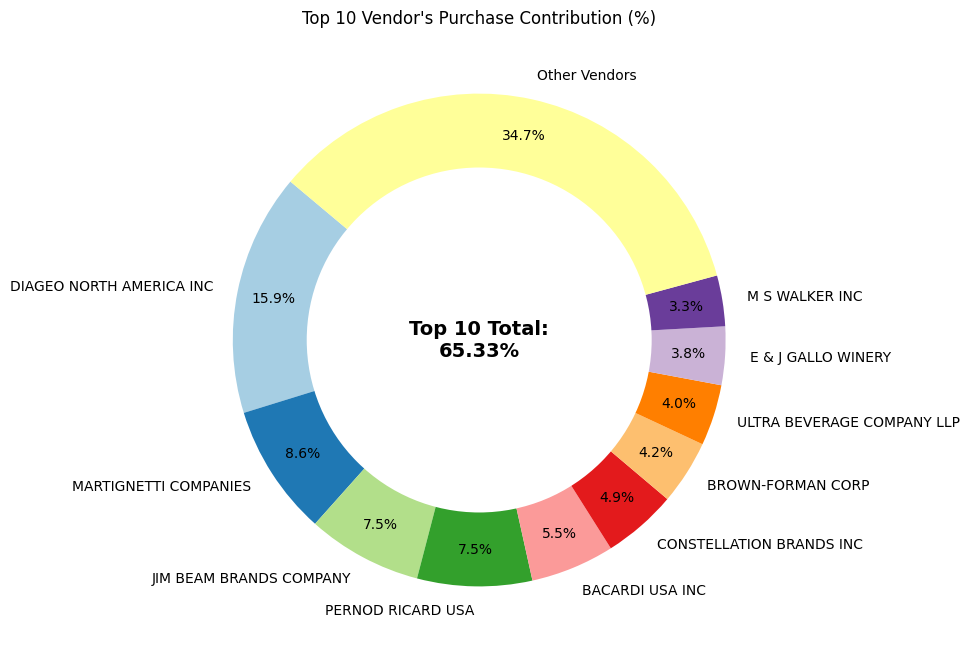

In [ ]:
# Creating a Donut chart to show top 10 vendors' Purchase Contribution. This is alternative to above Bar plot. 

vendors = list(top_vendors ['VendorName'].values)   # storing top_vendors values in variable vendors.
purchase_contributions = list(top_vendors ['PurchaseContribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie (purchase_contributions, labels = vendors, autopct = '%1.1f%%',
                            startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle  = plt.Circle ((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')
plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [42]:
df ['UnitPurchasePrice'] = df ['TotalPurchaseDollars'] / df ['TotalPurchasequantity']

In [45]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchasequantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,SalestoPurchaseRatio,StockTurnover,GrossProfit,ProfitMargin%,UnitPurchasePrice
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,568196,20407678.04,2691277.24,1043996.80,68601.68,5.354587,3.916432,16596426.44,435.458694,26.27
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,640988,19276293.96,2246049.48,1177754.64,144929.24,5.067320,3.907558,15472252.74,406.731995,23.19
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,748560,18152482.40,1844560.60,1375416.28,123780.22,5.310377,3.994301,14734178.72,431.037734,18.24
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,801648,17903891.52,1680200.04,1472971.20,257032.07,5.489974,3.974812,14642693.58,448.997388,16.17
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,543352,16892430.48,2183113.12,998351.32,257032.07,5.587588,3.934226,13869224.47,458.758828,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,20,63.80,43.84,2.20,27100.41,24.166667,10.000000,61.16,2316.666667,1.32
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,536,262.64,5.88,28.16,50293.62,112.239316,89.333333,260.30,11123.931624,0.39
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,8,7.92,3.96,0.40,14069.87,5.351351,4.000000,6.44,435.135135,0.74
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,288,573.12,310.44,60.48,257032.07,389.877551,288.000000,571.65,38887.755102,1.47


In [ ]:
df["OrderSize"] = pd.qcut(df["TotalPurchasequantity"], q=3, labels=["Small", "Medium", "Large"]) #this is to divide totpurqty into 3 categories. q=3 means quantile.
                                                                    # Column will be divided into 3 quantile-based bins, each containing approximately one-third of the data points. 
                                                                       # These quantiles will then be labeled as "Small," "Medium," or "Large" according to the labels you specified

In [49]:
df[["OrderSize","TotalPurchasequantity"]]

,OrderSize,TotalPurchasequantity
0,Large,145080
1,Large,164038
2,Large,187407
3,Large,201682
4,Large,138109
...,...,...
10687,Small,2
10688,Small,6
10689,Small,2
10690,Small,1


In [51]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\1505448859.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('OrderSize')[['UnitPurchasePrice']].mean()


,UnitPurchasePrice
OrderSize,
Small,39.342338
Medium,17.303654
Large,11.168201


C:\Users\n8nik\AppData\Local\Temp\ipykernel_9396\2120356000.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")


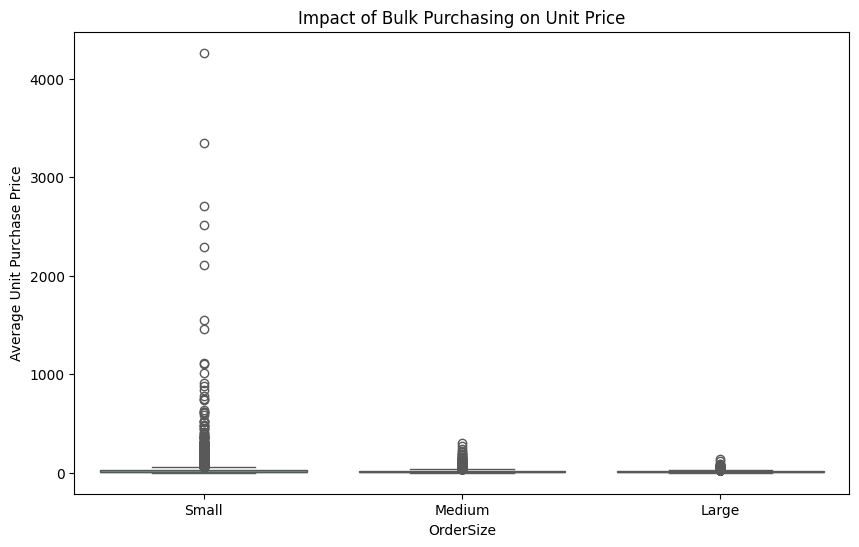

In [52]:
# To represent the above in a box plot.

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("OrderSize")
plt.ylabel("Average Unit Purchase Price")
plt.show()

FROM THE ABOVE WE CAN CONCLUDE THAT:

* Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
* The price difference between Small and Large orders is substantial (~72% reduction in unit cost)
* This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.

#### **Which vendors have low inventory turnover, indicating excess stock and slow-moving products?**

In [57]:
df[df['StockTurnover']<1].groupby('VendorName')[["StockTurnover"]].mean().sort_values('StockTurnover',ascending=True).head(10)
# below are all slow stock moving vendors. Their performance is not good.

,StockTurnover
VendorName,
DIAGEO CHATEAU ESTATE WINES,0.666667
PERNOD RICARD USA,0.666667
TREASURY WINE ESTATES,0.666667
VINEXTRA INC,0.666667
Circa Wines,0.708333
FORTUNE WINE BROKERS LLC,0.722222
TRINCHERO FAMILY ESTATES,0.750000
SHAW ROSS INT L IMP LTD,0.750000
SOUTHERN GLAZERS W&S OF NE,0.761905


#### **How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?**

In [62]:
df["UnsoldInventoryValue"] = ((df ["TotalPurchasequantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]).abs()
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))


Total Unsold Capital: 931.88M


In [ ]:
#Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
27,DIAGEO NORTH AMERICA INC,148.98M
61,MARTIGNETTI COMPANIES,80.09M
72,PERNOD RICARD USA,70.15M
49,JIM BEAM BRANDS COMPANY,69.21M
7,BACARDI USA INC,53.89M
22,CONSTELLATION BRANDS INC,45.78M
13,BROWN-FORMAN CORP,39.46M
111,ULTRA BEVERAGE COMPANY LLP,36.77M
32,E & J GALLO WINERY,35.62M
57,M S WALKER INC,31.14M


#### What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors..

In [65]:
top_threshold = df["TotalSalesDollars"].quantile(0.75) # if more than 75% then its top-performing vendor
low_threshold= df["TotalSalesDollars"].quantile(0.25)  # if less than 25% then its low-performing vendor

In [68]:
top_vendors = df[df["TotalSalesDollars"] >= top_threshold] ["ProfitMargin%"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold] ["ProfitMargin%"].dropna()

In [ ]:
#Creating a function to calculate confidence interval

def confidence_interval(data, confidence = 0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data)) # Standard error
    t_critical = stats.t.ppf((1+ confidence)/2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (490.36, 510.87), Mean: 500.61
Low Vendors 95% CI: (753.96, 930.79), Mean: 842.38


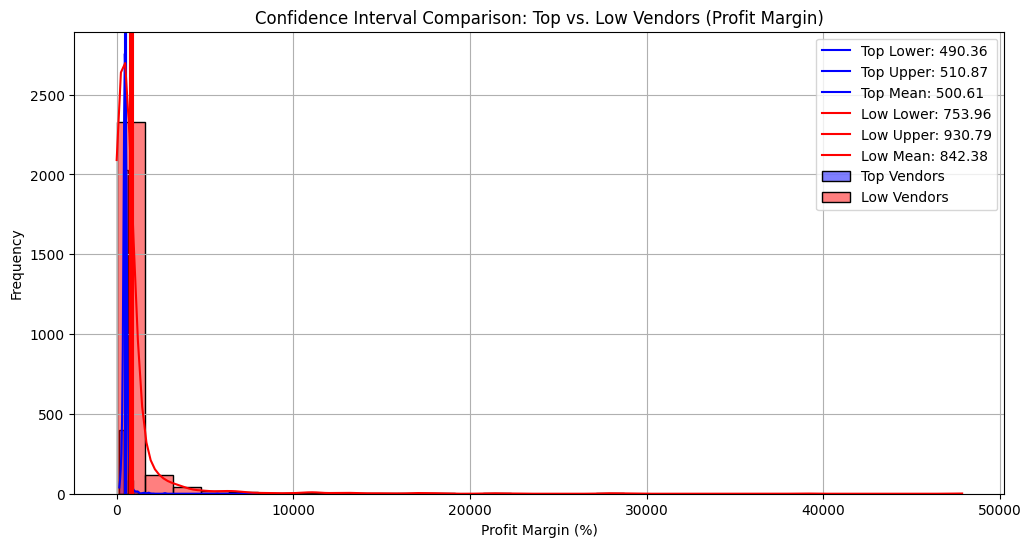

In [75]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

#Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="-", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="-", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="-", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="-", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

* The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).
* This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.
* For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.
* For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.